In [ ]:
# [Nur Colab] Diese Zellen müssen nur auf *Google Colab* ausgeführt werden und installieren Packete und Daten
!wget -q https://raw.githubusercontent.com/KI-Campus/AMALEA/master/requirements.txt && pip install --quiet -r requirements.txt
!wget --quiet "https://github.com/KI-Campus/AMALEA/releases/download/data/data.zip" && unzip -q data.zip
!wget --quiet "https://github.com/KI-Campus/AMALEA/releases/download/images/images.zip" && unzip -q images.zip

# Abschauen ist erwünscht!

## Autoencoder für semantische Segmentierung

### Semantische Segmentierung

Auf CNN basierende Modelle wurden in großer Vielfalt aufgebaut, um verschiedene Aufgaben zu lösen. Allgemein lassen sich die Herausforderungen der Klassifizierung, der semantischen Segmentierung, Objekterkennung und Instanzensegmentierung unter komplexeren neueren wie Keypoint Detection oder DensePose etc benennen.
Die Zuweisung einer Objektklasse, die in einem Bild als Ganzes eine Objektklasse zuzuordnen ist, wird als Klassifizierung bezeichnet. Während bei der semantischen Segmentierung alle Pixel durch die Objektklassen, auf die sie sich beziehen, identifiziert werden müssen. Im Gegensatz zur Klassifizierung können mehrere Objektklassen in einem Bild vorkommen.



### Segnet - Ein Autoencoder für semantische Segmentierung

Basierend auf [Kitti Road dataset](http://www.cvlibs.net/datasets/kitti/eval_road.php). Ein Segmentierungsdatensatz für autonomes Fahren, der vom __Karlsruher Institut für Technologie (KIT)__, dem MPI Tübingen und der University of Toronto erstellt wurde.


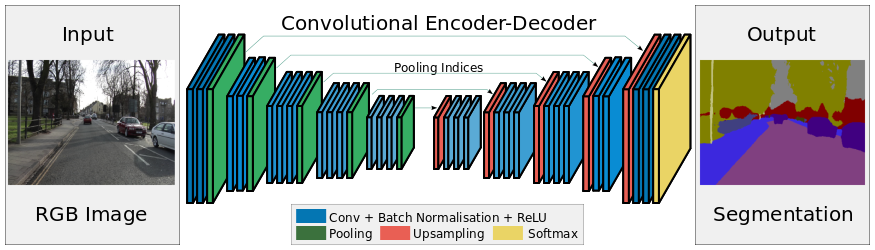


                                    Quelle: http://mi.eng.cam.ac.uk/projects/segnet/

Es ist möglich, diese Klassifizierungsaufgabe zu lösen, indem man am Ende eine Softmax-Schicht verwendet oder ein gegebenes RGB-Bild regressiert. Im letzteren Fall sind die RGB-Werte möglicherweise nicht genau gleich und es gibt eine intrinsische Ordnung in den Klassen. Auch wenn anschließend ein Schwellenwert verwendet wird, ist der Dimensionsraum allerdings viel kleiner. Im Allgemeinen sollte man sich für den ersten Ansatz entscheiden, da er das Problem als reguläre Klassifikationsaufgabe löst und gängige Praxis ist. Es ist nicht empfehlenswert, dies in einer Regression anzuwenden. Der zweite Ansatz dient nur dazu, alternative Wege zu zeigen, wie man ein Problem angehen kann (und zum Spaß).

Die Netzwerkarchitektur eines Autoencoders verwendet eine Struktur, die oft vorher auf einigen Daten wie [ImageNet](http://www.image-net.org/) trainiert wurde. Die Idee ist, dass diese Gewichte bereits etwas mit der späteren Aufgabe gemeinsam haben, so dass das Training schneller und möglicherweise besser konvergiert, als wenn man mit zufälligen Gewichten anfängt. In der obigen SegNet-Architektur wird die Standard-Klassifikationsnetzarchitektur `VGG-16` verwendet, um das Inputbild in einen höheren abstrakten Raum zu kodieren. Anschließend projizieren Upsampling und Faltungen die extrahierten Features zurück in den ursprünglichen Inputraum.

<div class="alert alert-block alert-success">
<b>Frage 5.4.1:</b> In welcher Stadt wurden die Bilder dieses Datensatzes erstellt?
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b></div>


### Kurze Wierderholung

Bevor wir beginnen, lassen Sie uns eine kleine Rekapitulation anhand der Bilder aus dem Video vornehmen, beginnend mit dem folgenden Bild:


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('images/original.png')

plt.figure(figsize=(18, 72))
plt.imshow(img)
plt.show()

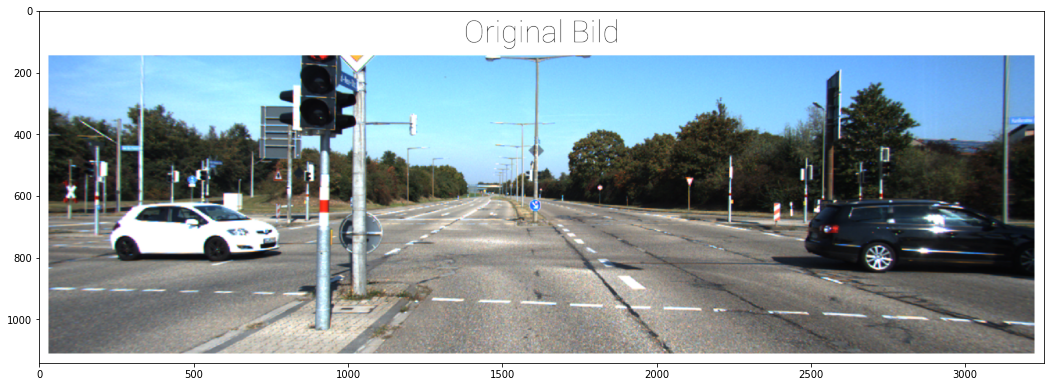
Als erstes wurde die Objekterkennung eingeführt. Ein Objektdetektor versucht, verschiedene, vordefinierte Objekte im Bild zu lokalisieren und zu klassifizieren. Dabei werden Bounding Boxes verwendet. Sie geben die Position des erkannten Objekts im Bild an. Zusätzlich wurde der Bounding Box ein Klassenlabel zugeordnet.

In [ ]:
img = Image.open('images/bounding_boxes.png')

plt.figure(figsize=(18, 72))
plt.imshow(img)
plt.show()

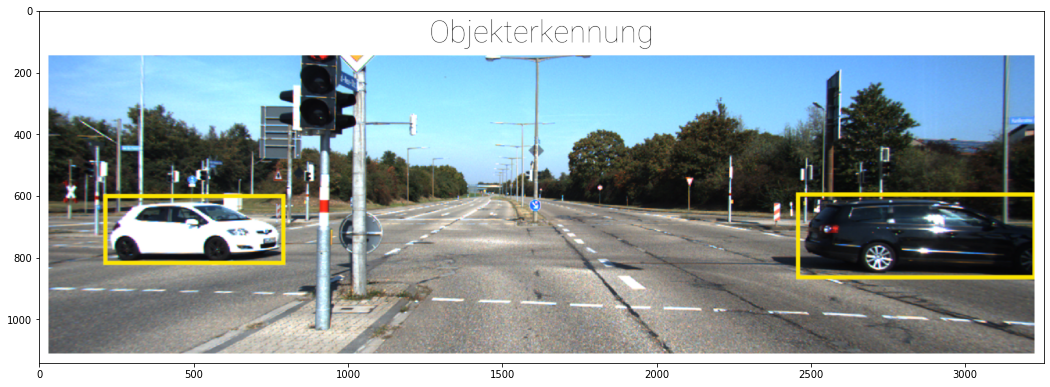
Des Weiteren wurde die Sematische Segmentierung eingeführt. Hierbei wird, im Vergleich zur Objektdetektion, das Bild eingefärbt statt Bounding Boxes zu berechnen. Das eingefärbte Bild wird im Folgenden auch als Maske bezeichnet. Ein weiterer Unterschied ist, dass sich bei der Objektdetektion Bounding Boxen überschneiden können - dies ist im Falle der Semantischen Segmentierung nicht möglich. Hierbei wird ein Pixel eindeutig zugeordnet.

In [ ]:
img = Image.open('images/semantic_segmentation.png')

plt.figure(figsize=(18, 72))
plt.imshow(img)
plt.show()

Zuletzt wurde die Instanz Segmentierung, als Erweiterung der Semantischen Segmentierung, vorgestellt. Diese kann zwischen verschiedenen Objekten der gleichen Klasse in einem Bild unterscheiden.

In [ ]:
img = Image.open('images/instance_segmentation.png')

plt.figure(figsize=(18, 72))
plt.imshow(img)
plt.show()

### Die Daten

Zuerst werden die Daten geladen. Der Datensatz befindet sich im Ordner data und muss aus dem Zip-Archiv entpackt werden. Bitte entpacken Sie den Datensatz im data-Ordner. Praktischerweise sind die Daten bereits in Training und Validierung aufgeteilt.
Die Variable `class_or_regr` dient zur Steuerung, ob eine Regression oder Klassifikation durchgeführt wird.
Im Falle, dass die Variable 1 ist, erfolgt eine Klassifikation; falls diese 0 ist, wird eine Regression durchgeführt.

In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import utils

In [ ]:
# As regression or classification?
# 0-regre, 1-classification

# Set class_or_regr 1 first.
class_or_regr = 1
root = 'data/dataset/'

path_train_img = root+'training/image_2'
path_train_gt_img = root+'training/semantic_rgb'

path_test_img = root+'testing/image_2'

x_train_semseg = np.load(root+'x_train.npy')
y_train_semseg = np.load(root+'y_train.npy')

x_val_semseg = np.load(root+'x_val.npy')
y_val_semseg = np.load(root+'y_val.npy')

In [ ]:
#### DO NOT EDIT
plt.subplots(figsize=(15, 15))
num_columns = 2
num_rows = 1

for i in range(0,2):
    plt.subplot(num_rows, num_columns, i+1)
    if i == 0:
        plt.title('Input Image')
        plt.imshow(x_train_semseg[0,:,:,:])  # Visualizes the input data
    else:
        plt.title('Ground Truth')
        plt.imshow(y_train_semseg[0,:,:,:])  # Visualizes the ground truth
    plt.axis('off')

### Die Labels

In [ ]:
#### DO NOT EDIT
# Load shortened form of labels with referring rgb values
rgb_array = np.load(root+'rgb_array.npy')

# Create bitmaps ... this will take some time
if class_or_regr == 1:
    y_train_bitmap = utils.transform_into_bitmap(y_train_semseg, rgb_array.tolist())
    y_val_bitmap = utils.transform_into_bitmap(y_val_semseg, rgb_array.tolist())

In [ ]:
# Visualize a bitmap of one class out of 29
if class_or_regr == 1:
    plt.title('Bitmap of one class')
    plt.imshow(y_train_bitmap[0,:,:,16])  # Visualize a bitmap of your desire
    plt.axis('off')

<div class="alert alert-block alert-success">
<b>Frage 5.4.2:</b> Wie viele Datenpunkte gibt es für Training und Validierung?
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b></div>


<div class="alert alert-block alert-success">
<b>Frage 5.4.3:</b> Erläutern Sie die Dimensionen der Bitmaps! (z. B.: y_train_bitmap[?,?,?,?])
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b></div>






### Data Augmentation mit numpy

Zuvor haben wir gelernt, dass wir die Anzahl unserer Trainingsdaten durch Datenvergrößerung erhöhen können.

<div class="alert alert-block alert-success">
<b>Aufgabe 5.4.4:</b> Im Folgenden werden die Bilder von uns selbst erweitert. Verwenden Sie "numpy"-Funktionen zum Erweitern der Bilder, wie in den Kommentaren beschrieben.
</div>

In [ ]:
#### DO NOT EDIT
plt.title('Orignal image')
plt.imshow(x_train_semseg[0,:,:,:])

In [ ]:
# Use a numpy function to flip the image horizontally

# STUDENT CODE HERE

# STUDENT CODE until HERE

In [ ]:
# Use a numpy function to rotate the image

# STUDENT CODE HERE

# STUDENT CODE until HERE

In [ ]:
# Use a numpy function to shift the image

# STUDENT CODE HERE

# STUDENT CODE until HERE

In [ ]:
#### DO NOT EDIT
# Execute this block to augment the data
# You can define which augmentation methods you would like to include
# in default all three methods are applied to the images in the training set

x_train_aug_semseg = utils.augment_images(x_train_semseg, h_flip=True, rotate180=True, shift_random=True)

if class_or_regr == 1:
    #Use the function to augment the ground_truth_bitmaps in the training set
    y_train_aug_bitmap = utils.augment_images(y_train_bitmap, h_flip=True, rotate180=True, shift_random=True)

elif class_or_regr == 0:
    # Use the function to augment the ground_truth_images in the training set
    y_train_aug_semseg = utils.augment_images(y_train_semseg, h_flip=True, rotate180=True, shift_random=True)


<div class="alert alert-block alert-success">
<b>Frage 5.4.5:</b> Erklären Sie in einigen Worten, warum wir eine Datenerweiterung durchführen wollen, insbesondere bei einem Datensatz wie dem Kitti.
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b></div>


<div class="alert alert-block alert-success">
<b>Frage 5.4.6:</b> Wie viele Datenpunkte gibt es nun (unter Verwendung aller angegebenen Augmentierungsmethoden)?
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b></div>


<div class="alert alert-block alert-success">
<b>Frage 5.4.7:</b> Warum wird das Bild um 180 Grad gedreht und nicht in 90-Grad-Schritten?
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b></div>


In [ ]:
#### DO NOT EDIT
# Visualize all possible augmentations of one image

plt.subplots(figsize=(15, 15))
num_columns = 2
num_rows = 4
nb_augments = int(x_train_aug_semseg.shape[0]/160)

for i in range(0, nb_augments):

    plt.subplot(num_rows, num_columns, i+1)
    plt.imshow(x_train_aug_semseg[i*160,:,:,:])
    plt.axis('off')

In [ ]:
#### DO NOT EDIT
# Visualize all possible augmentations of reffering ground truth bitmap of one class

plt.subplots(figsize=(15, 15))
num_columns = 2
num_rows = 4

for i in range(0,nb_augments):

    plt.subplot(num_rows, num_columns, i+1)

    if class_or_regr == 0:
        plt.imshow(y_train_aug_semseg[i*160,:,:])
    elif class_or_regr == 1:
        plt.imshow(y_train_aug_bitmap[i*160,:,:,16])
    plt.axis('off')

### Daten normalisieren

In [ ]:
#### DO NOT EDIT
x_train_aug_semseg.astype('float32')
x_val_semseg.astype('float32')

x_train_aug_semseg = x_train_aug_semseg / 255
x_val_semseg = x_val_semseg / 255

if class_or_regr == 0:
    # only divide in regression task, bitmaps are already between 0 and 1
    y_train_aug_semseg.astype('float32')
    y_val_semseg.astype('float32')
    y_train_aug_semseg = y_train_aug_semseg / 255
    y_val_semseg = y_val_semseg / 255

### Transfer Lernen mit dem VGG-16 Kodierer

In [ ]:
# Import the VGG-16 model and name it VGG16
# STUDENT CODE HERE

# STUDENT CODE until HERE

In [ ]:
#### DO NOT EDIT
vgg16_encoder = VGG16(weights='imagenet', include_top=False) # this might take some time to download
# vgg16_encoder.summary()

### Autoencoder

In [ ]:
# Use this to definitely change the name before training in combination with the next cell
from ipywidgets import widgets
from IPython.display import display
ae_specification = widgets.Text()
old_spec = 'None'

display(ae_specification)

def printer(sender):
    print(ae_specification.value)

ae_specification.on_submit(printer)

In [ ]:
# Check if the name changed.
print("The current training specification is referred to as", ae_specification.value)
if old_spec == ae_specification.value:
    print("There were no changes made to the previous training name!")


# Callbacks for tensorboard and save weights for the best performing period.
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
Acc_Logger = utils.LossGraph('acc')
tensorboard = TensorBoard(log_dir='logs/autoencoder_logs/'+ae_specification.value+'/')
Checkpoint = ModelCheckpoint('logs/autoencoder_logs/'+ae_specification.value+'/weights.hdf5'
                             , monitor='val_loss', save_best_only=True, save_weights_only=True, mode='auto',
                            save_freq = 1)

# Build the Autoencoder
autoencoder = utils.build_ae(vgg16_encoder, x_train_semseg.shape[1:], class_or_regr)

# Compile the models depending on the task
if class_or_regr == 0:

    autoencoder.compile(loss='mean_squared_error', metrics = ['accuracy'], optimizer='Adam')

    x_train_ae = x_train_aug_semseg
    y_train_ae = y_train_aug_semseg

    x_val_ae = x_val_semseg
    y_val_ae = y_val_semseg

    autoencoder.fit(x_train_ae, y_train_ae, batch_size = 4,#4
                epochs=1, validation_data=(x_val_ae, y_val_ae),
                callbacks=[Loss_Logger,tensorboard, Checkpoint], verbose=1)

elif class_or_regr == 1:

    autoencoder.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer='Adam')

    x_train_ae = x_train_aug_semseg
    y_train_ae = y_train_aug_bitmap

    x_val_ae = x_val_semseg
    y_val_ae = y_val_bitmap

    autoencoder.fit(x_train_ae, y_train_ae, batch_size = 4,#4
                epochs=1, validation_data=(x_val_ae, y_val_ae),
                callbacks=[Acc_Logger,tensorboard, Checkpoint], verbose=1)

# If training was successfull, do not use the same name again
old_spec = ae_specification.value

### Mit Ihrem Autoencoder vorhersagen

Es ist möglich, bereits vortrainierte Gewichte zu laden, um einige Vorhersagen zu erhalten.
Verwenden Sie dazu:
autoencoder.load_weights(path_to_weights)

Mögliche Gewichte:
- Der beste MSE trainiert 200 Epochen (/logs/autoencoder_logs/Regression200/weights.hdf5)
- Die beste Klassifikation trainiert 200 Epochen (/logs/autoencoder_logs/Classifier200/weights.hdf5)

Schauen Sie sich auch Ihre Tensorboard-Ergebnisse an.


<div class="alert alert-block alert-info">
<b>Hinweis:</b> Um die Regressionsergebnisse zu betrachten, ändern Sie <code>class_or_regr</code> im Unterabschnitt der Daten auf 0. Führen Sie alle nachfolgenden Blöcke aus. Es könnte einfacher sein, das Training zu überspringen, wenn nur die Ergebnisse der bereits trainierten Modelle interessant sind.



</div>

In [ ]:
# Loop through training images, and visualize those between lower and upper bound
# Validation images are index from 160 up to 200

# model.load_weights('path') #uncommend this if you want to use the pre-trained model weights, set the path by yourself

lower_bound = 160
upper_bound = 165

utils.ae_predict(autoencoder, path_train_img, path_train_gt_img, lower_bound, upper_bound,
                 ae_specification.value, class_or_regr)

### Abschließende Fragen:

<div class="alert alert-block alert-success">
<b>Frage 5.4.8:</b> Erklären Sie die Unterschiede zwischen den Varianten Regression und Klassifikation.
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b></div>


<div class="alert alert-block alert-success">
<b>Frage 5.4.9:</b> Was würden Sie vorschlagen, um Ihr Segmentierungsmodell zu verbessern?
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b></div>


### Weitere Informationen

[SegmentationForAutonomousDriving](https://blog.playment.io/semantic-segmentation-models-autonomous-vehicles/#U-Net)

[Dropout](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)

[BatchNormalization](https://arxiv.org/pdf/1502.03167.pdf)